# Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
from loader import *
from syngem_utils import *

In [3]:
torch.manual_seed(42)
np.random.seed(42)

# Load models

In [4]:
from synflow_args_helper import synflow_parser_args
syn_yaml_txt = open(f'Configs/synflow_FC.yml').read()

syn_loaded_yaml = yaml.load(syn_yaml_txt, Loader=yaml.FullLoader)

synflow_parser_args.__dict__.update(syn_loaded_yaml)


from Models.mlp import fc as syn_fc
input_shape, num_classes = (1, 28, 28), 10

rnd_model_21 = syn_fc(input_shape, num_classes)
rnd_model_21.load_state_dict(torch.load("./All_Results/Random-FC/rnd_21/post-model.pt", map_location=torch.device('cpu')))
rnd_model_21.eval()

rnd_model_42 = syn_fc(input_shape, num_classes)
rnd_model_42.load_state_dict(torch.load("./All_Results/Random-FC/rnd_42/post-model.pt", map_location=torch.device('cpu')))
rnd_model_42.eval()

rnd_model_63 = syn_fc(input_shape, num_classes)
rnd_model_63.load_state_dict(torch.load("./All_Results/Random-FC/rnd_63/post-model.pt", map_location=torch.device('cpu')))
rnd_model_63.eval();

# Get sparsity per layer

In [5]:
sprse_rnd_model_21 = check_sparsity(rnd_model_21, single = True)
sprse_rnd_model_42 = check_sparsity(rnd_model_42, single = True)
sprse_rnd_model_63 = check_sparsity(rnd_model_63, single = True)

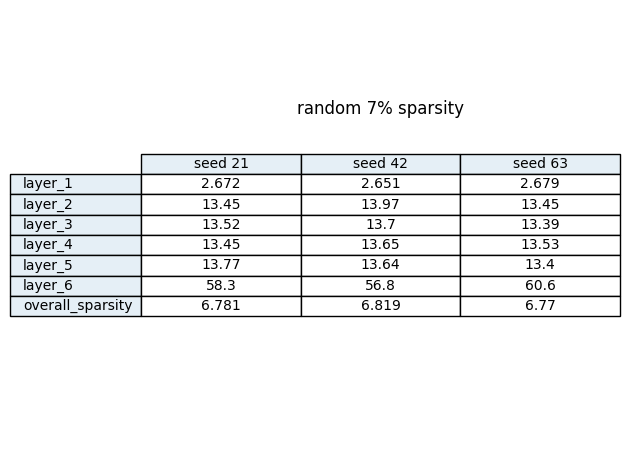

In [6]:
table = make_table(sprse_rnd_model_21, sprse_rnd_model_42, sprse_rnd_model_63, "random 7% sparsity")

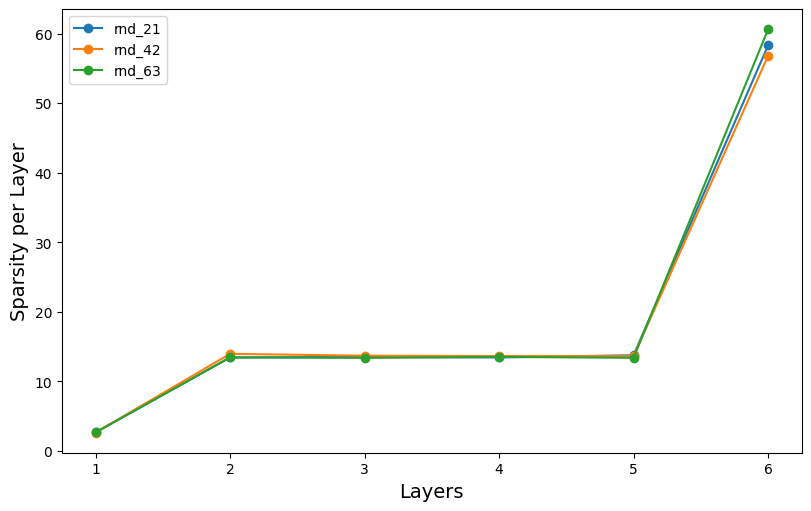

In [135]:
x_axis = [1,2,3,4,5,6]

fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')

ax.plot(x_axis,list(sprse_rnd_model_21.values())[:-1], label='rnd_21', marker='o')
ax.plot(x_axis,list(sprse_rnd_model_42.values())[:-1], label='rnd_42', marker='o')
ax.plot(x_axis,list(sprse_rnd_model_63.values())[:-1], label='rnd_63', marker='o')

ax.set_xlabel("Layers", fontsize=14)
ax.set_ylabel("Sparsity per Layer", fontsize=14)

ax.legend()
plt.savefig('rnd_7_sparse.pdf') 
plt.show()

# Plot accuracy

In [7]:
seed_21 = pd.read_pickle(f"./All_Results/Random-FC/rnd_21/post-train-rand.pkl")
seed_42 = pd.read_pickle(f"./All_Results/Random-FC/rnd_42/post-train-rand.pkl")
seed_63 = pd.read_pickle(f"./All_Results/Random-FC/rnd_63/post-train-rand.pkl")



df_seed_21 = seed_21.drop(["train_loss", "test_loss", "top5_accuracy"], axis = 1)
df_seed_42 = seed_42.drop(["train_loss", "test_loss", "top5_accuracy"], axis = 1)
df_seed_63 = seed_63.drop(["train_loss", "test_loss", "top5_accuracy"], axis = 1)

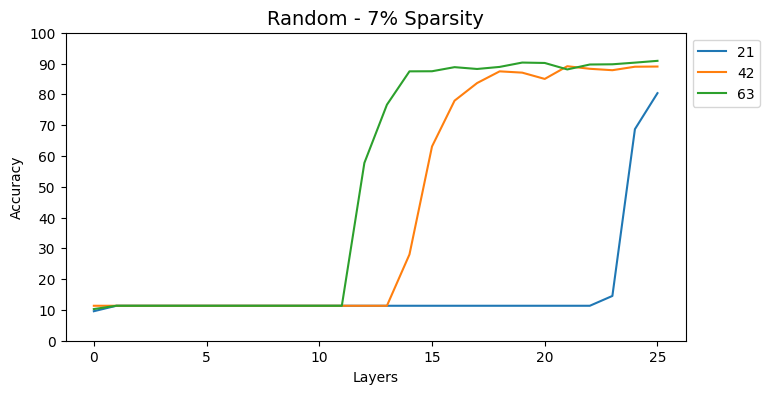

In [36]:
plt.figure(figsize=(8, 4))

plt.plot(df_seed_21)
plt.plot(df_seed_42)
plt.plot(df_seed_63)

plt.yticks(np.arange(0,110,10))
plt.legend(['21', '42', "63"], bbox_to_anchor=(1,1), loc="upper left")

plt.xlabel("Layers", fontsize=10)
plt.title("Random - 7% Sparsity", fontsize=14)
plt.ylabel("Accuracy", fontsize=10)


plt.savefig('rnd_7_acc.pdf') 
plt.show()

# Get units

In [9]:
rnd_fil_21 = get_filters(rnd_model_21)
rnd_fil_42 = get_filters(rnd_model_42)
rnd_fil_63 = get_filters(rnd_model_63)

In [10]:
rnd_positions_21 = get_weight_positions(rnd_fil_21)
rnd_positions_42 = get_weight_positions(rnd_fil_42)
rnd_positions_63 = get_weight_positions(rnd_fil_63)

In [11]:
rnd_weights_21 = get_model_weight_distances(rnd_fil_21)
rnd_weights_42 = get_model_weight_distances(rnd_fil_42)
rnd_weights_63 = get_model_weight_distances(rnd_fil_63)

In [14]:
rnd_clusters_21, counts_rnd_clusters_21, signs_rnd_clusters_21 = count_clusters(rnd_fil_21)
rnd_clusters_42, counts_rnd_clusters_42, signs_rnd_clusters_42 = count_clusters(rnd_fil_42)
rnd_clusters_63, counts_rnd_clusters_63, signs_rnd_clusters_63 = count_clusters(rnd_fil_63)

In [29]:
rnd_weights = []
rnd_clusters = []
rnd_clusters_signs = []
rnd_positions = []

for i in range(6):
    rnd_weights.append(np.concatenate((rnd_weights_21[i] , rnd_weights_42[i] , rnd_weights_63[i])))
    rnd_clusters.append(np.concatenate((rnd_clusters_21[i] , rnd_clusters_42[i] , rnd_clusters_63[i])))
    rnd_clusters_signs.append(np.concatenate((signs_rnd_clusters_21[i] , signs_rnd_clusters_42[i] , signs_rnd_clusters_63[i])))
    rnd_positions.append(np.concatenate((rnd_positions_21[i] , rnd_positions_42[i] , rnd_positions_63[i])))

In [16]:
for i in range(6) : 
    print(np.mean(np.nan_to_num(rnd_weights[i])))

0.19333333333333333
0.5966666666666667
0.62
0.6433333333333333
0.6333333333333333
1.1


In [17]:
for i in range(6):
    counts_rnd_clusters = np.concatenate((counts_rnd_clusters_21[i], counts_rnd_clusters_42[i], counts_rnd_clusters_63[i]))
    print(np.round(np.mean(np.nan_to_num(counts_rnd_clusters))))

3.0
3.0
3.0
3.0
3.0
4.0


In [18]:
for i in range(6) : 
    print(np.round(np.mean(np.nan_to_num(rnd_clusters[i]))))

8.0
5.0
5.0
5.0
5.0
17.0


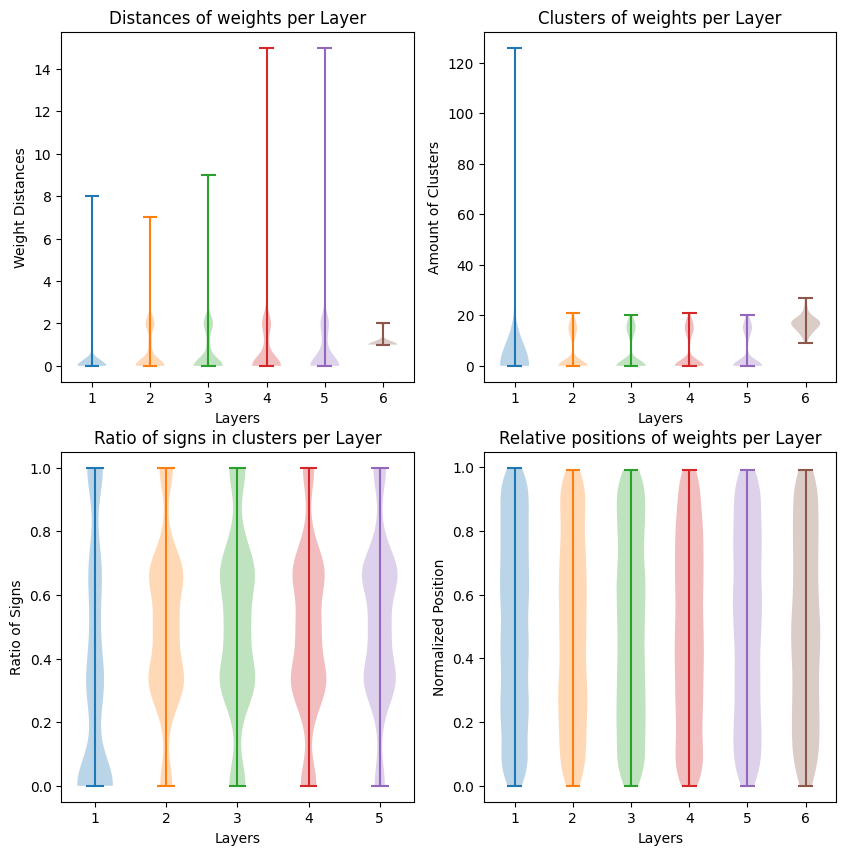

In [33]:
dists = [rnd_weights, rnd_clusters, rnd_clusters_signs, rnd_positions]


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
count = 0
for ax in axs.flat:
    
    if count == 0:
        for j in range(6):  
            ax.violinplot(np.nan_to_num(dists[count][j]), [j+1])
            ax.set_title(f"Distances of weights per Layer")
            ax.set_xlabel("Layers", fontsize=10)
            ax.set_ylabel("Weight Distances", fontsize=10)
    
    if count == 1:
        for j in range(6):  
            ax.violinplot(np.nan_to_num(dists[count][j]), [j+1])
            ax.set_title(f"Clusters of weights per Layer")
            ax.set_xlabel("Layers", fontsize=10)
            ax.set_ylabel("Amount of Clusters", fontsize=10)
            
    if count == 2:
        for j in range(5):  
            ax.violinplot(np.nan_to_num(dists[count][j]), [j+1])
            ax.set_title(f"Ratio of signs in clusters per Layer")
            ax.set_xlabel("Layers", fontsize=10)
            ax.set_ylabel("Ratio of Signs", fontsize=10)
            
            
    if count == 3:
        for j in range(6):  
            data = np.nan_to_num(dists[count][j])
            if j == 0:
                data = data / 784
            else:
                data = data / 100
            ax.violinplot(data, [j+1])
    
        ax.set_title(f"Relative positions of weights per Layer")
        ax.set_xlabel("Layers", fontsize=10)
        ax.set_ylabel("Normalized Position", fontsize=10)
            
            
    count += 1
    

plt.savefig('dists_rnd_7.pdf')  
plt.show()

In [38]:
import math

In [46]:
math.sqrt(5)

2.23606797749979

In [128]:
w = torch.empty(3, 5)
torch.nn.init.kaiming_uniform_(w,a=math.sqrt(5))

tensor([[-0.1345,  0.0906,  0.1693, -0.2499, -0.4167],
        [ 0.1519, -0.1859, -0.0598, -0.0046, -0.1029],
        [-0.0585, -0.3578, -0.2887, -0.2577,  0.1416]])

In [129]:
w

tensor([[-0.1345,  0.0906,  0.1693, -0.2499, -0.4167],
        [ 0.1519, -0.1859, -0.0598, -0.0046, -0.1029],
        [-0.0585, -0.3578, -0.2887, -0.2577,  0.1416]])

In [130]:
x,y = np.argwhere(w<0)

In [131]:
for i in range(len(x)):
    if np.random.randint(2) == 1:
        w[x[i]][y[i]] = abs(w[x[i]][y[i]])

In [132]:
w

tensor([[ 0.1345,  0.0906,  0.1693,  0.2499,  0.4167],
        [ 0.1519,  0.1859,  0.0598, -0.0046, -0.1029],
        [ 0.0585,  0.3578,  0.2887, -0.2577,  0.1416]])

In [ ]:
value_when_true if condition else value_when_false

In [101]:
w = np.where(w<0, abs(w) if np.random.randint(2) == 1 else w, w)

In [118]:
x,y = np.argwhere(w<0)

In [122]:
k = zip(x,y)

In [121]:
w[x[1]][y[1]]

tensor(-0.2224)

In [ ]:
for 

In [78]:
for i in w:
    if i < 0 and np.random.randint(2) == 1:
        abs(i)
        

RuntimeError: Boolean value of Tensor with more than one value is ambiguous